<a href="https://colab.research.google.com/github/Elwing-Chou/tibaml1027/blob/main/cifar10_gap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets.cifar10 import load_data
(x_train, y_train), (x_test, y_test) = load_data()

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [ ]:
# !!! (50000, 1) =/= (50000, )
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [ ]:
trans = [
    "airplane",										
    "automobile",										
    "bird",										
    "cat",										
    "deer",										
    "dog",										
    "frog",										
    "horse",										
    "ship",										
    "truck",
]

automobile


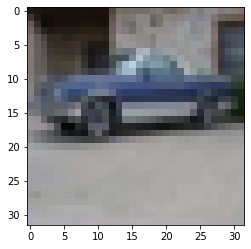

In [ ]:
import matplotlib.pyplot as plt
idx = 10000
print(trans[y_train[idx][0]])
plt.imshow(x_train[idx])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
layers = [
    # CNN
    Conv2D(64, 3, padding="same", activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(),
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(512, 3, padding="same", activation="relu"),
    GlobalAveragePooling2D(),
    Dense(10, activation="softmax")
]
model = Sequential(layers)
model.summary(line_length=100)

Model: "sequential_4"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d_16 (Conv2D)                          (None, 32, 32, 64)                      1792           
                                                                                                    
 max_pooling2d_16 (MaxPooling2D)             (None, 16, 16, 64)                      0              
                                                                                                    
 conv2d_17 (Conv2D)                          (None, 16, 16, 128)                     73856          
                                                                                                    
 max_pooling2d_17 (MaxPooling2D)             (None, 8, 8, 128)                       0              
                                                                     

In [ ]:
# 一個輸出(二元分類): BinaryCrossEntropy p log 1/q + (1 - p) log 1/1-q
# 多個輸出(多元分類): CategoricalCrossEntropy pi log1/qi
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              # "adam"也可以
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

In [ ]:
# batch_size: 看多少筆, 做一次梯度下降(幾10~幾100)
# epochs: 所有資料看幾輪(負責結束訓練)
# batch_size=200
# 一epochs: 54000 / 200 = 270(次梯度下降)
# verbose=0(quiet) 1(default) 2(no bar)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("cnn.h5", save_best_only=True)
]
model.fit(x_train_norm,
          y_train,
          batch_size=200,
          epochs=100,
          validation_split=0.1,
          verbose=2,
          callbacks=callbacks)

Epoch 1/100
225/225 - 9s - loss: 1.7044 - accuracy: 0.3658 - val_loss: 1.4331 - val_accuracy: 0.4724 - 9s/epoch - 41ms/step
Epoch 2/100
225/225 - 8s - loss: 1.3221 - accuracy: 0.5128 - val_loss: 1.2235 - val_accuracy: 0.5496 - 8s/epoch - 37ms/step
Epoch 3/100
225/225 - 8s - loss: 1.1334 - accuracy: 0.5945 - val_loss: 1.1322 - val_accuracy: 0.5946 - 8s/epoch - 37ms/step
Epoch 4/100
225/225 - 8s - loss: 1.0124 - accuracy: 0.6390 - val_loss: 1.0285 - val_accuracy: 0.6266 - 8s/epoch - 37ms/step
Epoch 5/100
225/225 - 8s - loss: 0.9221 - accuracy: 0.6735 - val_loss: 0.9207 - val_accuracy: 0.6770 - 8s/epoch - 37ms/step
Epoch 6/100
225/225 - 8s - loss: 0.8462 - accuracy: 0.6991 - val_loss: 0.8064 - val_accuracy: 0.7176 - 8s/epoch - 37ms/step
Epoch 7/100
225/225 - 8s - loss: 0.7705 - accuracy: 0.7289 - val_loss: 0.7780 - val_accuracy: 0.7318 - 8s/epoch - 37ms/step
Epoch 8/100
225/225 - 8s - loss: 0.7048 - accuracy: 0.7531 - val_loss: 0.8179 - val_accuracy: 0.7140 - 8s/epoch - 37ms/step
Epoch 9/

In [ ]:
model.evaluate(x_test_norm, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.6615 - accuracy: 0.7833


[0.6614746451377869, 0.78329998254776]